<a href="https://colab.research.google.com/github/dafsotomo/COVID19/blob/master/Clasificadorr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller 2 - Analítica de datos

#Construccion clasificador segun modelo de BAYES

Dario Fernando Soto Molina - 0815067

In [1]:
import os
import seaborn as sns
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.base import  BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Compute ROC curve and ROC area for each class

In [0]:
def roc_multiclass(ytrue,yscore):
    fpr = dict();    tpr = dict();     roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

Analisis exploratorio basico - base de datos housing

In [0]:
def pre_exploratorio(Xtrain_pre,ytrain_pre,path_img,col_sal,w,h,Np=None):
    #exploratorio basico -> Normalizar + reduccion de dimensionalidad
    normalizar = StandardScaler()
    #escoger aleatoriamente puntos para evitar costo computacional - analisis inicial
    if Np == None: Np = len(Xtrain_pre.index)
    
    ind = np.random.randint(0,len(Xtrain_pre.index),Np) #escoger subconjunto de datos
    
    Xz = normalizar.fit_transform(Xtrain_pre.iloc[ind,:])
    yc = ytrain_pre[ind].reshape(-1)
    
    #reduccion de dimension con pca y tsne
    red_pca = PCA()
    perplexity = np.round(0.75*np.sqrt(Np))
    red_tsne = TSNE(n_components=2,perplexity = perplexity, n_iter = 250,verbose = 10)
        
    Xred_pca = pd.DataFrame(red_pca.fit_transform(Xz))
    Xred_tsne = pd.DataFrame(red_tsne.fit_transform(Xz))
  
    #Relevancia por variabilidad
    var_ret = 0.95
    rel_vec,Mv,ind_rel = rel_pca(red_pca,var_ret)
    
    #graficar
    sval = 30
    #pca 2D
    Xred_pca.plot(kind="scatter",x=0,y=1,
               c = yc, s=sval, label = col_sal,
              colormap = "jet",colorbar=True, sharex=False)    
    plt.title('PCA 2D')
    plt.xlabel('Componente principal 1')
    plt.ylabel('Componente principal 2')
    save_fig(path_img,"red_PCA2D")
    plt.show()
    
    #relevancia pca 2D     
    plt.imshow(rel_vec.reshape(w,h),cmap='jet')
    plt.ylabel('Relevancia PCA - eigenfaces')
    plt.title('RELEVANCIA PCA - eigenfaces, var_ret=%.2f' % (var_ret))
    plt.colorbar()
    save_fig(path_img,"relevancia_PCA_eigenface")
    plt.show()
    #tsne 2D
    Xred_tsne.plot(kind="scatter",x=0,y=1,
               c = yc, s = sval, label = col_sal,
              colormap = "jet",colorbar=True, sharex=False)    
    plt.title('t-sne 2D - Perp.=%.2f' % perplexity)
    plt.xlabel('Embebimiento - Dim. 1')
    plt.ylabel('Embebimiento - Dim. 2')
    save_fig(path_img,"tsne_2D")
    plt.show()
    return True

Relevancia por variabilidad con pca

In [0]:
def rel_pca(red,var_exp):
    Mv = np.min(np.where(np.cumsum(red.explained_variance_ratio_)
                         >var_exp))
    M,P = red.components_.shape
    #print(P,M)
    rel_vec = np.zeros((P))
    for i in range(Mv):
        #print(i)
        rel_vec += abs(red.explained_variance_ratio_[i]*red.components_[i,:])
    
    rel_vec = rel_vec/sum(rel_vec)
    rel_vec = rel_vec - min(rel_vec)
    rel_vec = rel_vec/max(rel_vec)
    
    ind_rel = rel_vec.argsort()[::-1]
    return rel_vec, Mv,ind_rel

Guardar figuras

In [0]:
from google.colab import files
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path) 

Curva ROC

In [0]:
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):   
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))

    save_fig(path_img,title)
    plt.show()

This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Lectura

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
#base de datos
from sklearn.datasets import fetch_lfw_people
#https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

%matplotlib inline
#descargar base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Datos tipo pandas

Dimensiones tipo pandas:  (1288, 1850)
<class 'numpy.ndarray'>


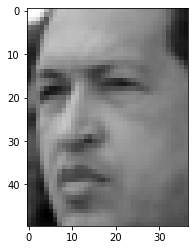

In [9]:
Xdata = pd.DataFrame(lfw_people.data)
Xdat = Xdata.values
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
plt.imshow(np.array(Xdata.iloc[0,:]).reshape(lfw_people.images.shape[1],lfw_people.images.shape[2]),cmap='gray')
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdat,y,test_size=0.9)
print(type(Xdat))

Clase custom bayes

In [0]:
from sklearn.base import  BaseEstimator, ClassifierMixin
from scipy.stats import multivariate_normal as mn
class Gauss(BaseEstimator,ClassifierMixin):
    #inicializacion de clase y variables
    def __init__(self, priors = None, alpha=1e-5, tipo = 'cuadratico'): #constructor clase con hyperparámetros
        self.priors = priors
        self.alpha = alpha
        self.tipo = tipo
        return None
    def fit(self,X,y,*_): #entrenamiento
        self.clases = np.unique(y) # tipos de clases
        Nc = len(self.clases)
        P = X.shape[1] #numero de atributos
        #encontrar media y Cov por cada clase
        self.mu = np.zeros((Nc,P)) 
        self.Cov = np.zeros((Nc,P,P))
        self.pdfs = Nc*[None]
        for i in self.clases:
            self.mu[i] = X[y==i,:].mean(axis=0)
            if self.tipo == 'cuadratico':
              self.Cov[i] = np.cov(X[y==i,:].T)
              val,vec = np.linalg.eig(self.Cov[i])
              if np.real(abs(val.any())) < self.alpha:
                self.Cov[i] = self.Cov[i] + self.alpha*np.eye(self.Cov[i].shape[0])
              self.pdfs[i] = mn(self.mu[i], self.Cov[i],allow_singular='true') # objeto scipy ara evaluar o muestrear gaussiana multivariada
            if self.tipo =='ingenuo':
              self.Cov[i] = np.cov(X[y==i,:].T)
              self.pdfs[i] = mn(self.mu[i], self.Cov[i],allow_singular='true')
            if self.tipo=='lineal':
              self.Cov[i] == self.reg_cov(np.cov(X[y==i,:].T),aplha= self.alpha)
        if self.tipo=='lineal':
          for i in self.clases:
            self.Cov[i]=self.priors[i]*self.Cov[i]
          for i in self.clases:
            self.Cov[i]=sum(self.Cov)
          for i in self.clases:
            self.pdfs[i] = mn(self.mu[i], self.Cov[i]) 
        return self

    def predict(self,X,*_):
        y = np.zeros((X.shape[0],len(self.clases)))
        for i in self.clases:
          if self.tipo =='cuadratico':
            y[:,i] = self.pdfs[i].pdf(X) 
          if self.tipo=='ingenuo':
            y[:,i] = self.pdfs[i].pdf(X)*self.priors[i] 
          if self.tipo=='lineal':
            y[:,i] = self.pdfs[i].pdf(X)
        return y.argmax(axis=1)


In [11]:
Ges=Gauss()
Ges.fit(Xtrain,ytrain,0.001)

Gauss(alpha=1e-05, priors=None, tipo='cuadratico')

In [12]:
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KN


from sklearn.externals import joblib #https://joblib.readthedocs.io/en/latest/


steps=[[('cla', Gauss())],
       [('rep',  PCA()),('cla', SGDClassifier(loss="log"))],
       [('cla', LogisticRegression())],
       [('cla', LDA())],
       [('cla', QD())],
       [('cla', SVC())],
       [('cla', RF())],
       [('cla', KN())],
      ]
       
        
parameters = [{
              'cla__tipo' : ['lineal','cuadratico'],              
              'cla__alpha': [0.0001],
              },
              {
              'rep__n_components' : [0.8,0.9],              
              'cla__alpha': [0.0001,0.001,0.01],
              },
              {        

              'cla__C': [0.5,1],
              },
              {    
             'cla__solver': ['svd','eigen'],
              },
              {
               'cla__tol': [0.0001,0.001],
              },
              {
               'cla__C': [0.5,1],
               'cla__kernel': ['linear','poly'],
               'cla__degree': [2,3],
              },
              {
               'cla__n_estimators': [50,100,150],
              },
              {
               'cla__n_neighbors': [3,5,8],
               'cla__p': [1,2,3],
              }
             ]

label_models = ['Gauss','PCA_SGD','Logistic', 'LDA','QuadDiscr','SVC','RandFor','KNeigh']

best_model = []
filename = ''#'resultados/people_comp'
for i in range(len(steps)): #modelos
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='balanced_accuracy',verbose=10)
    grid_search.fit(Xtrain, ytrain)
    #print(grid_search.cv_results_)
    #mejor modelo entrenado
    best_model += [grid_search.best_estimator_]
    joblib.dump(best_model,filename+".pkl")

print('Mejores modelos:\n')
best_model

modelo 1/8
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.1min finished


modelo 2/8
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1162s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1862s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.0s finished


modelo 3/8
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.1s finished


modelo 4/8
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1181s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.1s finished


modelo 5/8
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.5s finished


modelo 6/8
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0896s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.8s finished


modelo 7/8
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.9s finished


modelo 8/8
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0377s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0871s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Batch computation too slow (3.2426s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.2s finished


Mejores modelos:



[Pipeline(memory=None,
          steps=[('cla', Gauss(alpha=0.0001, priors=None, tipo='cuadratico'))],
          verbose=False), Pipeline(memory=None,
          steps=[('rep',
                  PCA(copy=True, iterated_power='auto', n_components=0.9,
                      random_state=None, svd_solver='auto', tol=0.0,
                      whiten=False)),
                 ('cla',
                  SGDClassifier(alpha=0.01, average=False, class_weight=None,
                                early_stopping=False, epsilon=0.1, eta0=0.0,
                                fit_intercept=True, l1_ratio=0.15,
                                learning_rate='optimal', loss='log',
                                max_iter=1000, n_iter_no_change=5, n_jobs=None,
                                penalty='l2', power_t=0.5, random_state=None,
                                shuffle=True, tol=0.001, validation_fraction=0.1,
                                verbose=0, warm_start=False))],
          verbose=False

Evaluar sobre Xtest

Evaluando modelo 1/8
Guardando... Gauss


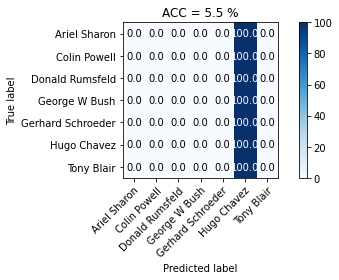

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        69
     Colin Powell       0.00      0.00      0.00       218
  Donald Rumsfeld       0.00      0.00      0.00       107
    George W Bush       0.00      0.00      0.00       483
Gerhard Schroeder       0.00      0.00      0.00        92
      Hugo Chavez       0.06      1.00      0.10        64
       Tony Blair       0.00      0.00      0.00       127

         accuracy                           0.06      1160
        macro avg       0.01      0.14      0.01      1160
     weighted avg       0.00      0.06      0.01      1160

Evaluando modelo 2/8
Guardando... PCA_SGD


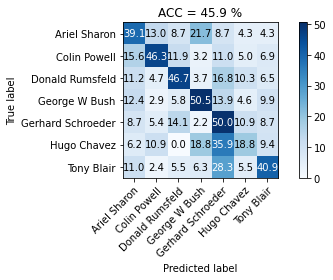

                   precision    recall  f1-score   support

     Ariel Sharon       0.17      0.39      0.24        69
     Colin Powell       0.70      0.46      0.56       218
  Donald Rumsfeld       0.38      0.47      0.42       107
    George W Bush       0.84      0.51      0.63       483
Gerhard Schroeder       0.21      0.50      0.29        92
      Hugo Chavez       0.16      0.19      0.17        64
       Tony Blair       0.37      0.41      0.39       127

         accuracy                           0.46      1160
        macro avg       0.40      0.42      0.39      1160
     weighted avg       0.59      0.46      0.50      1160

Evaluando modelo 3/8
Guardando... Logistic


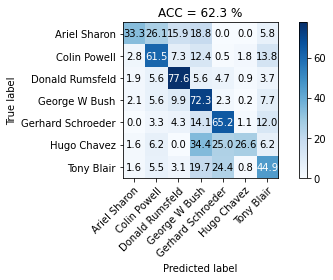

                   precision    recall  f1-score   support

     Ariel Sharon       0.52      0.33      0.41        69
     Colin Powell       0.67      0.61      0.64       218
  Donald Rumsfeld       0.50      0.78      0.61       107
    George W Bush       0.77      0.72      0.74       483
Gerhard Schroeder       0.48      0.65      0.56        92
      Hugo Chavez       0.68      0.27      0.38        64
       Tony Blair       0.39      0.45      0.42       127

         accuracy                           0.62      1160
        macro avg       0.57      0.54      0.54      1160
     weighted avg       0.64      0.62      0.62      1160

Evaluando modelo 4/8
Guardando... LDA


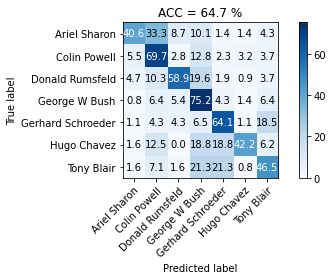

                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.41      0.46        69
     Colin Powell       0.64      0.70      0.67       218
  Donald Rumsfeld       0.59      0.59      0.59       107
    George W Bush       0.78      0.75      0.77       483
Gerhard Schroeder       0.46      0.64      0.54        92
      Hugo Chavez       0.60      0.42      0.50        64
       Tony Blair       0.47      0.46      0.47       127

         accuracy                           0.65      1160
        macro avg       0.58      0.57      0.57      1160
     weighted avg       0.65      0.65      0.65      1160

Evaluando modelo 5/8
Guardando... QuadDiscr


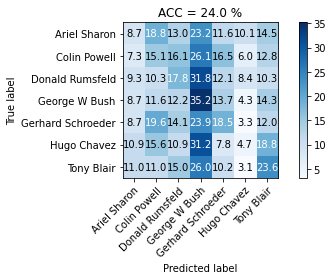

                   precision    recall  f1-score   support

     Ariel Sharon       0.06      0.09      0.07        69
     Colin Powell       0.21      0.15      0.18       218
  Donald Rumsfeld       0.12      0.18      0.14       107
    George W Bush       0.48      0.35      0.41       483
Gerhard Schroeder       0.11      0.18      0.14        92
      Hugo Chavez       0.05      0.05      0.05        64
       Tony Blair       0.18      0.24      0.20       127

         accuracy                           0.24      1160
        macro avg       0.17      0.18      0.17      1160
     weighted avg       0.29      0.24      0.26      1160

Evaluando modelo 6/8
Guardando... SVC


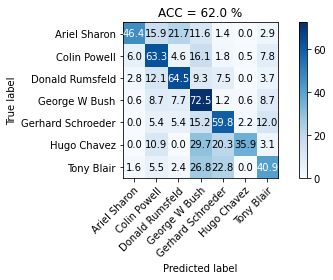

                   precision    recall  f1-score   support

     Ariel Sharon       0.60      0.46      0.52        69
     Colin Powell       0.62      0.63      0.63       218
  Donald Rumsfeld       0.50      0.64      0.56       107
    George W Bush       0.74      0.72      0.73       483
Gerhard Schroeder       0.47      0.60      0.53        92
      Hugo Chavez       0.79      0.36      0.49        64
       Tony Blair       0.40      0.41      0.40       127

         accuracy                           0.62      1160
        macro avg       0.59      0.55      0.55      1160
     weighted avg       0.63      0.62      0.62      1160

Evaluando modelo 7/8
Guardando... RandFor


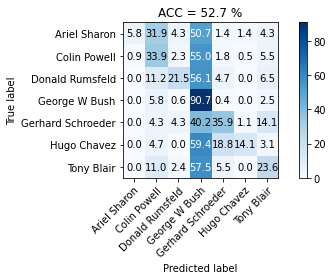

                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.06      0.11        69
     Colin Powell       0.47      0.34      0.39       218
  Donald Rumsfeld       0.56      0.21      0.31       107
    George W Bush       0.55      0.91      0.68       483
Gerhard Schroeder       0.52      0.36      0.42        92
      Hugo Chavez       0.75      0.14      0.24        64
       Tony Blair       0.38      0.24      0.29       127

         accuracy                           0.53      1160
        macro avg       0.56      0.32      0.35      1160
     weighted avg       0.53      0.53      0.47      1160

Evaluando modelo 8/8
Guardando... KNeigh


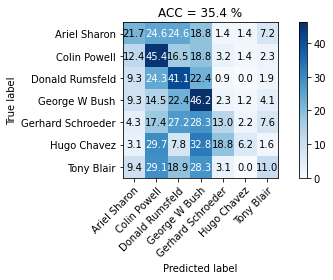

                   precision    recall  f1-score   support

     Ariel Sharon       0.13      0.22      0.16        69
     Colin Powell       0.35      0.45      0.39       218
  Donald Rumsfeld       0.17      0.41      0.24       107
    George W Bush       0.58      0.46      0.51       483
Gerhard Schroeder       0.25      0.13      0.17        92
      Hugo Chavez       0.25      0.06      0.10        64
       Tony Blair       0.26      0.11      0.15       127

         accuracy                           0.35      1160
        macro avg       0.28      0.26      0.25      1160
     weighted avg       0.39      0.35      0.36      1160



In [14]:
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %d/%d' % (i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)
     
    plot_confusion_matrix(
                          ytest, ytest_e, 
                          classes=lfw_people.target_names,
                          normalize=True,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    save_fig(path_img,label_models[i])                      
    plt.show()
    
    cr = classification_report(
                               ytest, ytest_e, 
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )                          
    #support = #muestras en la clase estudiada
    print(cr)

Evaluando ROC modelo 2/8
Guardando... ROC curve PCA_SGD


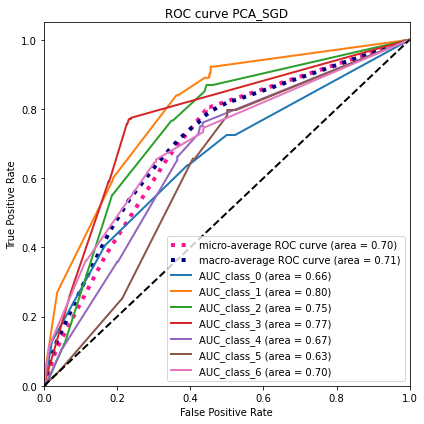

Evaluando ROC modelo 3/8
Guardando... ROC curve Logistic


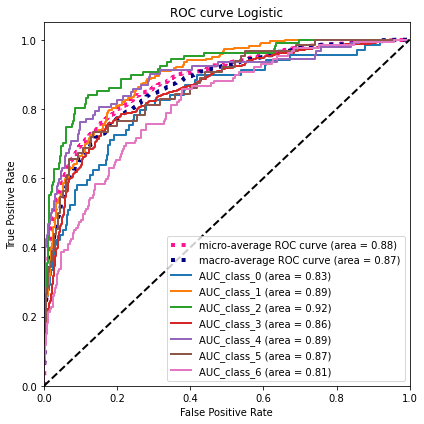

Evaluando ROC modelo 4/8
Guardando... ROC curve LDA


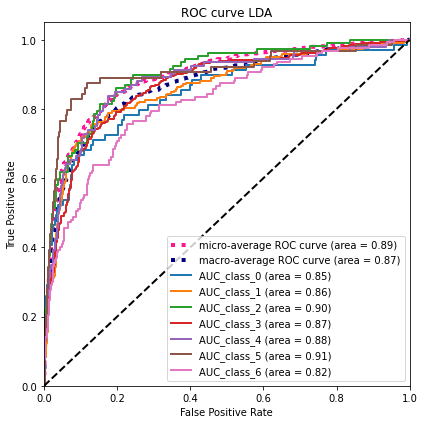

Evaluando ROC modelo 5/8
Guardando... ROC curve QuadDiscr


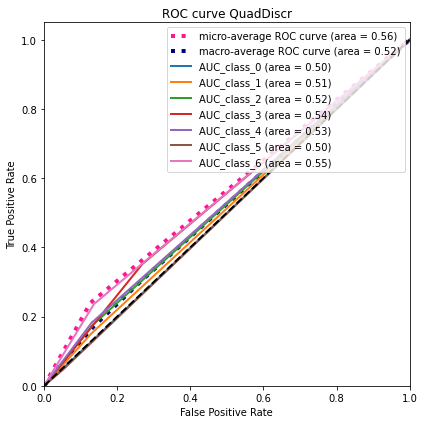

Evaluando ROC modelo 6/8
Evaluando ROC modelo 6/8
Guardando... ROC curve SVC


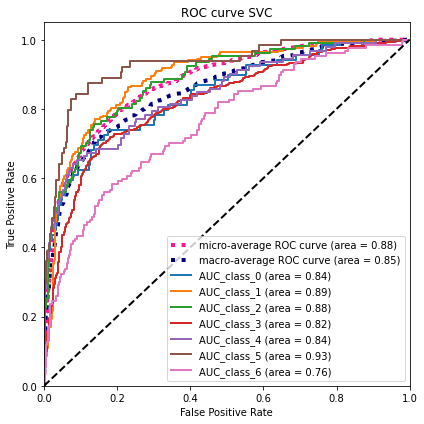

Evaluando ROC modelo 7/8
Guardando... ROC curve RandFor


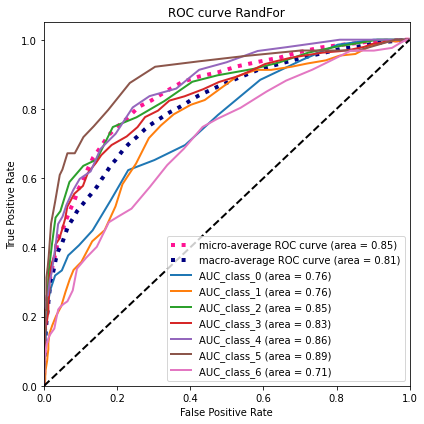

Evaluando ROC modelo 8/8
Guardando... ROC curve KNeigh


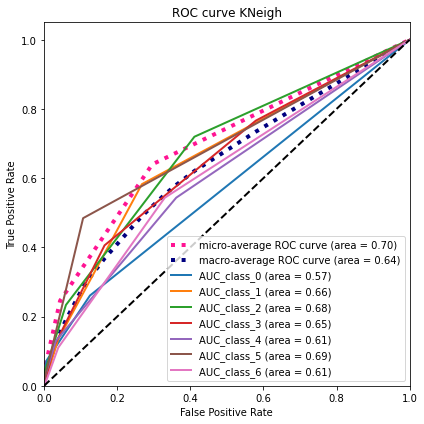

In [15]:
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings("ignore")
ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
  if i!=0:
    try:
      print('Evaluando ROC modelo %d/%d' % (i+1,len(my_model_loaded)))
      ytest_score = my_model_loaded[i].predict_proba(Xtest) #debe calcularse la funcion de decision o el posterior de la probabilidad
      roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
      roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)
    except:
      print('Evaluando ROC modelo %d/%d' % (i+1,len(my_model_loaded)))
      ytest_score = my_model_loaded[i].decision_function(Xtest) #debe calcularse la funcion de decision o el posterior de la probabilidad
      roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
      roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)